In [1]:
# Importacion de Librerias y Data Set

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

file_path = "/content/DATA_SET_SUR_V2_Modificado.csv"

df = pd.read_csv(file_path)

Separar Variables de Entrada y Salida y escalamiento de datos

In [2]:
# Separar entradas (primeras 14 columnas) y salidas (últimas 5 columnas)
input_columns = df.iloc[:, :14]
output_columns = df.iloc[:, 14:19]

# Escalar los datos entre 0 y 1
scaler_in = MinMaxScaler()
scaler_out = MinMaxScaler()

X_scaled = scaler_in.fit_transform(input_columns)
y_scaled = scaler_out.fit_transform(output_columns)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Cambiar la forma de las entradas para la RNN (agregar dimensión de tiempo)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Funcion de costos para optimizar el combustible

In [3]:
"""
def custom_fuel_loss(y_true, y_pred):
    fuel_true = y_true[:, 0:1]  # Tomar la columna 'Fuel Consumed' (index 0) como un tensor
    fuel_pred = y_pred[:, 0:1]  # Tomar la columna 'Fuel Consumed' (index 0) como un tensor
    return K.mean(K.square(fuel_true - fuel_pred))  # Mean Squared Error solo para 'Fuel Consumed'
"""

def custom_fuel_and_delta_loss(y_true, y_pred):

    # Parámetros de ponderación
    alpha = 0.2  # Importancia de Fuel
    beta = 0.8  # Importancia de Delta VN

    # Extraer las columnas correspondientes a Fuel Consumed y Delta VN
    fuel_true = y_true[:, 0:1]  # Fuel Consumed
    fuel_pred = y_pred[:, 0:1]  # Fuel Consumed
    delta_vn_true = y_true[:, 3:4]  # Delta VN (columna 4, índice 3)
    delta_vn_pred = y_pred[:, 3:4]  # Delta VN

    # Pérdida para Fuel Consumed (MSE)
    loss_fuel = tf.reduce_mean(tf.square(fuel_true - fuel_pred))  # MSE para Fuel
    # Pérdida para Delta VN (MSE)
    huber_loss = Huber(delta=2.0)
    loss_delta_vn = huber_loss(delta_vn_true, delta_vn_pred)  # Usar Huber Loss
    #loss_delta_vn = tf.reduce_mean(tf.square(delta_vn_true - delta_vn_pred))  # MSE para Delta VN

    # Pérdida total (combinación lineal de ambas)
    total_loss = alpha * loss_fuel + beta * loss_delta_vn
    return total_loss

Construir Modelo RNN con LSTM

In [4]:


model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(150,return_sequences=True))
model.add(LSTM(128))
model.add(Dense(100, activation='relu'))
model.add(Dense(5))  # 5 salidas correspondientes a las 5 columnas

"""
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(512, activation='relu'))  # Capa densa más grande
model.add(Dense(5))  # 5 salidas
"""
# Definir la tasa de aprendizaje
learning_rate = 0.0003  # Ajusta este valor según sea necesario
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo con la función de costo personalizada
model.compile(optimizer=optimizer, loss=custom_fuel_and_delta_loss)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compilar Entrenar y Evaluar el modelo


In [5]:
# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.0005), loss=custom_fuel_and_delta_loss)

# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2)

# Evaluación del modelo
loss = model.evaluate(X_test, y_test)
print(f"Pérdida total en el conjunto de prueba: {loss}")

# Predicción y desescalado de la salida completa
y_pred_scaled = model.predict(X_test)
y_pred = scaler_out.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_out.inverse_transform(y_test)

# Mostrar algunas predicciones y valores reales
for i in range(5):
    print(f"Predicción: {y_pred[i]}, Valor Real: {y_test_unscaled[i]}")

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 0.1033 - val_loss: 0.0763
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0932 - val_loss: 0.0535
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0571 - val_loss: 0.0203
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0295 - val_loss: 0.0198
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0202 - val_loss: 0.0159
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0122 - val_loss: 0.0149
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0166 - val_loss: 0.0130
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0131 - val_loss: 0.0137
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0114 - val_loss: 0.0127
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0109 - val_loss: 0.0125
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0097 - val_loss: 0.0126
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0128 - val_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
--- Métricas para Delta VN ---
MAE (Error absoluto medio) para Delta VN: 0.10605310234799975
MSE (Error cuadrático medio) para Delta VN: 0.025257689663726806
RMSE (Raíz del Error Cuadrático Medio) para Delta VN: 0.1589266801507123
Error Relativo (%) para Delta VN: 3.45%

--- Métricas para Fuel Consumed ---
MAE (Error absoluto medio) para Fuel Consumed: 0.15065804983799663
MSE (Error cuadrático medio) para Fuel Consumed: 0.03352718690997763
RMSE (Raíz del Error Cuadrático Medio) para Fuel Consumed: 0.18310430609348768
Error Relativo (%) para Fuel Consumed: 4.58%

--- Predicciones vs Valores Reales para Delta VN ---
Predicción: -2.8232, Valor Real: -2.7420
Predicción: -4.3482, Valor Real: -4.2630
Predicción: -4.3118, Valor Real: -4.3720
Predicción: -2.8241, Valor Real: -2.7440
Predicción: -4.3663, Valor Real: -4.2380

--- Predicciones vs Valores Reales para Fuel Consumed ---
Predicción: 2.4990, Valor Real: 2.4250

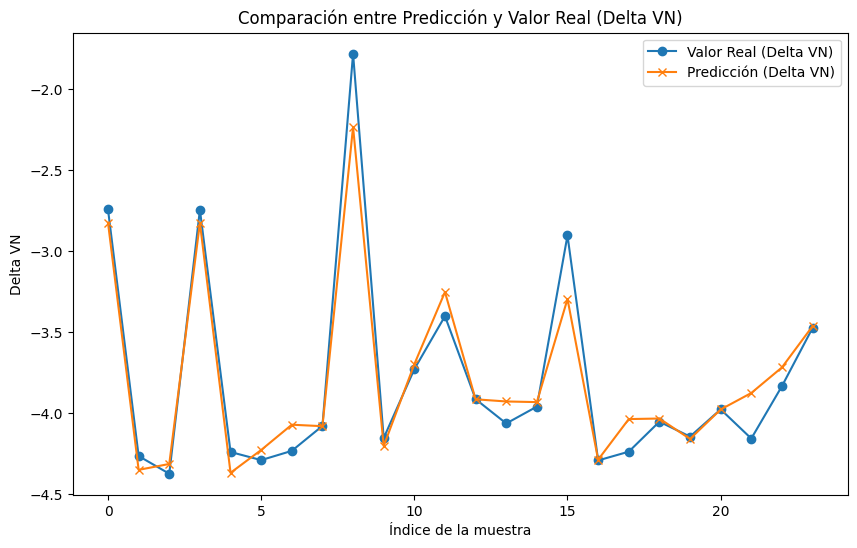

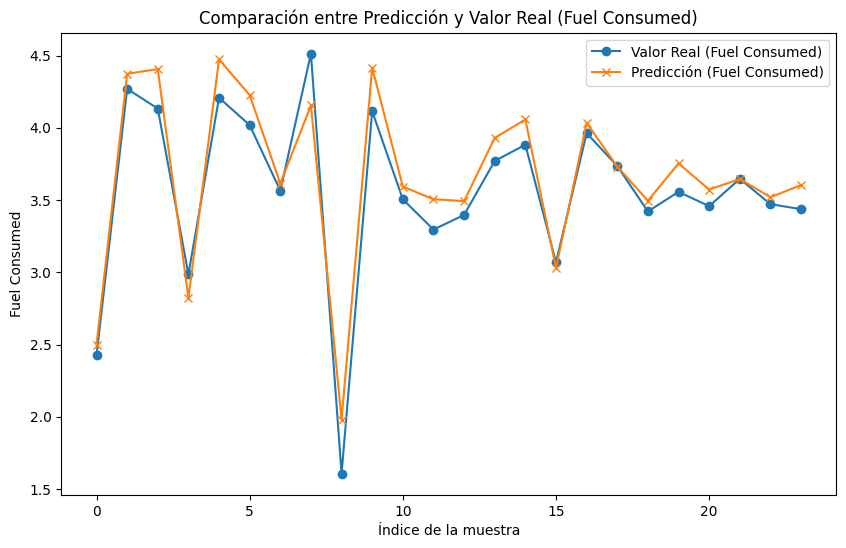

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extraer las columnas de Delta VN (columna 3) y Fuel Consumed (columna 0) de las predicciones y valores reales
fuel_test = y_test[:, 0:1]  # Columna 1 (índice 0) de los valores reales (Fuel Consumed)
fuel_pred = model.predict(X_test)[:, 0:1]  # Columna 1 (índice 0) de los valores predichos (Fuel Consumed)

delta_vn_test = y_test[:, 3:4]  # Columna 4 (índice 3) de los valores reales (Delta VN)
delta_vn_pred = model.predict(X_test)[:, 3:4]  # Columna 4 (índice 3) de los valores predichos (Delta VN)

# Desescalar los valores para ver las diferencias reales
fuel_test_unscaled = scaler_out.inverse_transform(np.concatenate([fuel_test, np.zeros((fuel_test.shape[0], 4))], axis=1))[:, 0]
fuel_pred_unscaled = scaler_out.inverse_transform(np.concatenate([fuel_pred, np.zeros((fuel_pred.shape[0], 4))], axis=1))[:, 0]

delta_vn_test_unscaled = scaler_out.inverse_transform(np.concatenate([np.zeros((delta_vn_test.shape[0], 3)), delta_vn_test, np.zeros((delta_vn_test.shape[0], 1))], axis=1))[:, 3]
delta_vn_pred_unscaled = scaler_out.inverse_transform(np.concatenate([np.zeros((delta_vn_pred.shape[0], 3)), delta_vn_pred, np.zeros((delta_vn_pred.shape[0], 1))], axis=1))[:, 3]

# Calcular las métricas de error para Delta VN
mae_delta_vn = mean_absolute_error(delta_vn_test_unscaled, delta_vn_pred_unscaled)
mse_delta_vn = mean_squared_error(delta_vn_test_unscaled, delta_vn_pred_unscaled)
rmse_delta_vn = np.sqrt(mse_delta_vn)
error_relativo_delta_vn = np.mean(np.abs((delta_vn_test_unscaled - delta_vn_pred_unscaled) / delta_vn_test_unscaled)) * 100

# Calcular las métricas de error para Fuel Consumed
mae_fuel = mean_absolute_error(fuel_test_unscaled, fuel_pred_unscaled)
mse_fuel = mean_squared_error(fuel_test_unscaled, fuel_pred_unscaled)
rmse_fuel = np.sqrt(mse_fuel)
error_relativo_fuel = np.mean(np.abs((fuel_test_unscaled - fuel_pred_unscaled) / fuel_test_unscaled)) * 100

# Mostrar las métricas para Delta VN
print(f"--- Métricas para Delta VN ---")
print(f"MAE (Error absoluto medio) para Delta VN: {mae_delta_vn}")
print(f"MSE (Error cuadrático medio) para Delta VN: {mse_delta_vn}")
print(f"RMSE (Raíz del Error Cuadrático Medio) para Delta VN: {rmse_delta_vn}")
print(f"Error Relativo (%) para Delta VN: {error_relativo_delta_vn:.2f}%")

# Mostrar las métricas para Fuel Consumed
print(f"\n--- Métricas para Fuel Consumed ---")
print(f"MAE (Error absoluto medio) para Fuel Consumed: {mae_fuel}")
print(f"MSE (Error cuadrático medio) para Fuel Consumed: {mse_fuel}")
print(f"RMSE (Raíz del Error Cuadrático Medio) para Fuel Consumed: {rmse_fuel}")
print(f"Error Relativo (%) para Fuel Consumed: {error_relativo_fuel:.2f}%")

# Comparar algunas predicciones y valores reales para Delta VN
print("\n--- Predicciones vs Valores Reales para Delta VN ---")
for i in range(5):
    print(f"Predicción: {delta_vn_pred_unscaled[i]:.4f}, Valor Real: {delta_vn_test_unscaled[i]:.4f}")

# Comparar algunas predicciones y valores reales para Fuel Consumed
print("\n--- Predicciones vs Valores Reales para Fuel Consumed ---")
for i in range(5):
    print(f"Predicción: {fuel_pred_unscaled[i]:.4f}, Valor Real: {fuel_test_unscaled[i]:.4f}")

# Graficar las predicciones vs los valores reales para Delta VN
plt.figure(figsize=(10, 6))
plt.plot(delta_vn_test_unscaled[:50], label='Valor Real (Delta VN)', marker='o')
plt.plot(delta_vn_pred_unscaled[:50], label='Predicción (Delta VN)', marker='x')
plt.xlabel('Índice de la muestra')
plt.ylabel('Delta VN')
plt.title('Comparación entre Predicción y Valor Real (Delta VN)')
plt.legend()
plt.show()

# Graficar las predicciones vs los valores reales para Fuel Consumed
plt.figure(figsize=(10, 6))
plt.plot(fuel_test_unscaled[:50], label='Valor Real (Fuel Consumed)', marker='o')
plt.plot(fuel_pred_unscaled[:50], label='Predicción (Fuel Consumed)', marker='x')
plt.xlabel('Índice de la muestra')
plt.ylabel('Fuel Consumed')
plt.title('Comparación entre Predicción y Valor Real (Fuel Consumed)')
plt.legend()
plt.show()


Guardar Pesos Mejores Resultados

In [ ]:
model.save('best_model.h5')

In [ ]:
|import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1️⃣ Cargar el archivo CSV con las 11 maniobras
file_path_verificacion = 'Datos_de_Verificacion.csv'  # Ruta del archivo
try:
    df_verificacion = pd.read_csv(file_path_verificacion, sep=';', engine='python')  # Usar separador ; para dividir columnas
    if df_verificacion.shape[1] == 1:  # Si solo se detecta 1 columna, cambiar a sep=','
        df_verificacion = pd.read_csv(file_path_verificacion, sep=',', engine='python')
    print("\n--- Archivo cargado correctamente ---\n")
except Exception as e:
    print("\n--- Error al cargar el archivo ---\n", e)

# 2️⃣ Verificar si el archivo se cargó correctamente
print("\n--- Vista previa de los primeros registros ---\n")
print(df_verificacion.head())

# 3️⃣ Tomar solo las 14 columnas de entrada
input_columns = df_verificacion.iloc[:, :14]  # Seleccionar las primeras 14 columnas de entrada
print("\n--- Verificación de las columnas de entrada ---\n")
print(input_columns.head())

# 4️⃣ Convertir las columnas de fechas a timestamps
# Suponiendo que la columna 1 y la columna 6 son fechas (ajústalo si es necesario)
try:
    input_columns.iloc[:, 1] = pd.to_datetime(input_columns.iloc[:, 1], errors='coerce')  # Columna 2 (índice 1)
    input_columns.iloc[:, 6] = pd.to_datetime(input_columns.iloc[:, 6], errors='coerce')  # Columna 7 (índice 6)
    print("\n--- Se convirtieron las fechas a timestamps ---\n")
except Exception as e:
    print("\n--- Error al convertir las fechas ---\n", e)

# Convertir las fechas a minutos desde el inicio del año
try:
    start_of_year = pd.Timestamp(year=2024, month=1, day=1, hour=0, minute=0, second=0)
    input_columns.iloc[:, 1] = (input_columns.iloc[:, 1] - start_of_year).dt.total_seconds() / 60  # Convertir a minutos
    input_columns.iloc[:, 6] = (input_columns.iloc[:, 6] - start_of_year).dt.total_seconds() / 60  # Convertir a minutos
except Exception as e:
    print("\n--- Error al convertir las fechas a minutos ---\n", e)

# 5️⃣ Convertir todo el DataFrame a numérico
try:
    input_columns = input_columns.apply(pd.to_numeric, errors='coerce')  # Convertir todas las columnas a números
    input_columns = input_columns.fillna(0)  # Rellenar los NaN con 0
except Exception as e:
    print("\n--- Error al convertir las columnas a numéricas ---\n", e)

# 6️⃣ Escalar los datos de entrada
try:
    scaler_in = MinMaxScaler()
    X_new_scaled = scaler_in.fit_transform(input_columns)  # Escalar los nuevos datos de entrada
except Exception as e:
    print("\n--- Error al escalar los datos de entrada ---\n", e)

# 7️⃣ Ajustar la forma de las entradas para la RNN
try:
    X_new_scaled = np.reshape(X_new_scaled, (X_new_scaled.shape[0], 1, X_new_scaled.shape[1]))  # Dar forma (11, 1, 14)
except Exception as e:
    print("\n--- Error al ajustar la forma de los datos ---\n", e)

# 8️⃣ Usar el modelo ya cargado para predecir las 5 salidas
try:
    predictions_scaled = model.predict(X_new_scaled)  # Usar el modelo cargado para predecir
except Exception as e:
    print("\n--- Error al predecir las salidas ---\n", e)

# 9️⃣ Desescalar las salidas (5 columnas de salida)
try:
    scaler_out = MinMaxScaler()
    scaler_out.fit(df_train.iloc[:, 14:19])  # Usar las salidas originales del entrenamiento
    predictions = scaler_out.inverse_transform(predictions_scaled)  # Desescalar las predicciones
except Exception as e:
    print("\n--- Error al desescalar las salidas ---\n", e)

# 🔟 Mostrar las 5 salidas de las 11 maniobras
try:
    predicciones_df = pd.DataFrame(predictions, columns=['Fuel Consumed', 'Delta Vr Ranging', 'Delta Vt Ranging', 'Delta Vn Ranging', 'Thruster Coefficient Ranging'])
    print("\n--- Predicciones de las 5 salidas para las 11 maniobras ---\n")
    print(predicciones_df)
except Exception as e:
    print("\n--- Error al mostrar las salidas ---\n", e)



--- Archivo cargado correctamente ---


--- Vista previa de los primeros registros ---

   Maniobra        Maneuver Date  Delta Vr  Delta Vt  Delta Vn  \
0         1  2024/01/04 05:25:50     0.218         0     4.281   
1         2  2024/01/26 04:24:21     0.199         0     3.917   
2         3  2024/02/23 02:49:28     0.206         0     4.051   
3         4  2024/04/02 22:52:35     0.203         0     4.004   
4         5  2024/05/03 20:05:42     0.204         0     4.010   

   Thruster Coeficient                Epcoh  Semi Major Axis  Excentricity  \
0                 0.93  2024/01/01 01:00:00      42165297.53      0.000338   
1                 0.93  2024/01/23 17:00:00      42166793.44      0.000424   
2                 0.93  2024/02/20 17:00:00      42166515.57      0.000418   
3                 0.93  2024/03/31 17:00:00      42165404.47      0.000316   
4                 0.93  2024/05/01 17:00:00      42166406.10      0.000307   

   Inclination       RAAN  Arg OF Perigee  Me

MAPA DE CALOR

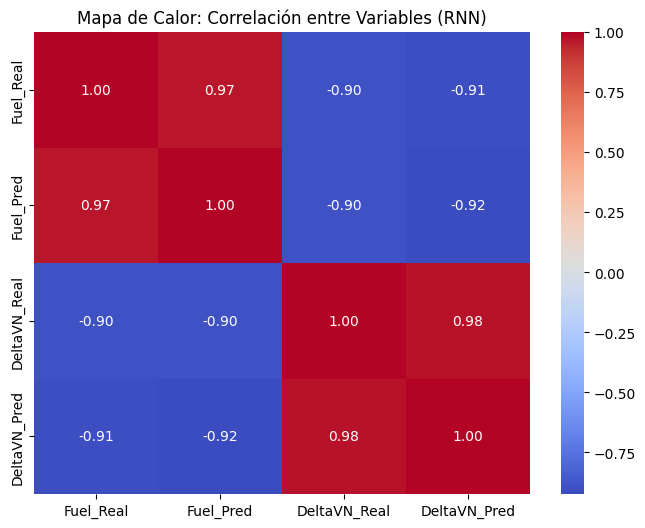

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extraer las predicciones y los valores reales para Fuel Consumed y Delta VN
fuel_test = y_test_unscaled[:, 0]  # Columna 0: Fuel Consumed
fuel_pred = y_pred[:, 0]

delta_vn_test = y_test_unscaled[:, 3]  # Columna 3: Delta VN
delta_vn_pred = y_pred[:, 3]

# Crear un DataFrame con los valores reales y predichos
results_df_rnn = pd.DataFrame({
    "Fuel_Real": fuel_test,
    "Fuel_Pred": fuel_pred,
    "DeltaVN_Real": delta_vn_test,
    "DeltaVN_Pred": delta_vn_pred
})

# Calcular la matriz de correlación
correlation_matrix_rnn = results_df_rnn.corr()

# Crear el mapa de calor para la correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_rnn, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Calor: Correlación entre Variables (RNN)")
plt.show()
